In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from skimage.util import random_noise
from skimage import img_as_ubyte

# Load and normalize MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add channel dimension (for grayscale)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
# Add Gaussian noise
def add_noise(image, mode='gaussian'):
    noisy_img = random_noise(image, mode=mode)
    return img_as_ubyte(noisy_img)

# Apply Gaussian blur
import cv2

def apply_blur(image, kernel_size=5):
    blurred_img = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    return blurred_img

# Degrade the training data
x_train_noisy = np.array([add_noise(img) for img in x_train])
x_test_noisy = np.array([add_noise(img) for img in x_test])

In [3]:
# Encoder
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Compile autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Training the autoencoder
autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.1155 - val_loss: 0.1140
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1122 - val_loss: 0.1140
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1117 - val_loss: 0.1140
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1115 - val_loss: 0.1140
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1122 - val_loss: 0.1140
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1122 - val_loss: 0.1140
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/st

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Average PSNR: 9.73 dB


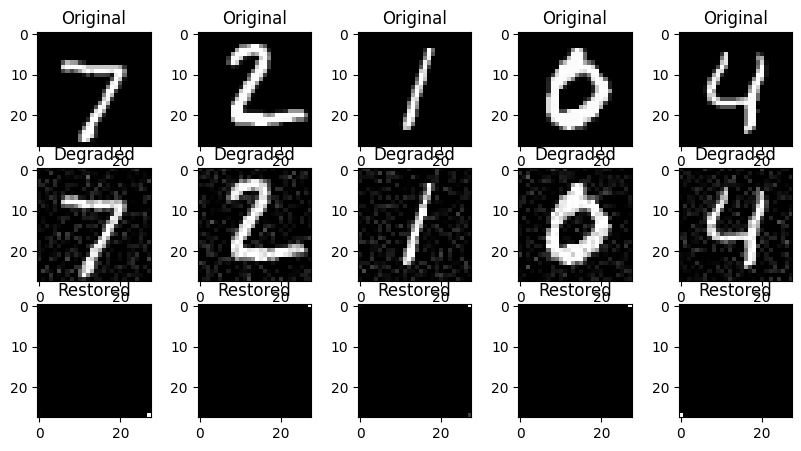

In [5]:
from skimage.metrics import peak_signal_noise_ratio as psnr

# Predict on test images
decoded_imgs = autoencoder.predict(x_test_noisy)

# Calculate PSNR
psnr_values = [psnr(x_test[i], decoded_imgs[i]) for i in range(len(x_test))]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr:.2f} dB')

# Plot original, degraded, and restored images
n = 5
plt.figure(figsize=(10, 5))
for i in range(n):
    plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title('Original')

    plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title('Degraded')

    plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title('Restored')
plt.show()


TASK 2


In [6]:

# In Colab or Jupyter Notebook
!pip install tensorflow keras numpy matplotlib

In [7]:
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

# Load CIFAR-100
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [8]:
# Load VGG16 (Pre-trained)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add custom layers for CIFAR-100 classification
x = Flatten()(vgg_model.output)
x = Dense(512, activation='relu')(x)
output = Dense(100, activation='softmax')(x)

vgg16_model = Model(inputs=vgg_model.input, outputs=output)

# Freeze initial layers
for layer in vgg_model.layers:
    layer.trainable = False

vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,028,644 (57.33 MB)

 Trainable params: 313,956 (1.20 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
# Train VGG16 on CIFAR-100
vgg16_model.fit(x_train, y_train,
                epochs=10,
                batch_size=64,
                validation_data=(x_test, y_test))


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.4340 - loss: 2.1508 - val_accuracy: 0.3686 - val_loss: 2.5196
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4570 - loss: 2.0446 - val_accuracy: 0.3672 - val_loss: 2.5355
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.4803 - loss: 1.9544 - val_accuracy: 0.3653 - val_loss: 2.5427
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.4981 - loss: 1.8867 - val_accuracy: 0.3664 - val_loss: 2.5550
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.5168 - loss: 1.8050 - val_accuracy: 0.3728 - val_loss: 2.5489
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.5364 - loss: 1.7301 - val_accuracy: 0.3707 - val_loss: 2.5684
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.5456 - loss: 1.6716 - val_accuracy: 0.3755 - val_loss: 2.5894
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5719 - loss: 1.5875 - 

In [11]:
import time

# Evaluate performance
start_time = time.time()
vgg16_score = vgg16_model.evaluate(x_test, y_test, verbose=0)
vgg16_time = time.time() - start_time

print(f"VGG16 Accuracy: {vgg16_score[1] * 100:.2f}%")
print(f"VGG16 Inference Time: {vgg16_time:.2f} seconds")


VGG16 Accuracy: 36.59%
VGG16 Inference Time: 5.60 seconds


In [12]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical

# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)


In [13]:
# AlexNet model
def alexnet_model(input_shape=(32, 32, 3), num_classes=100):
    model = Sequential()

    # Conv Layer 1
    model.add(Conv2D(96, (3, 3), strides=1, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Conv Layer 2
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Conv Layer 3
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Conv Layer 4
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Conv Layer 5
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Flatten Layer
    model.add(Flatten())

    # Fully Connected Layer 1
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # Fully Connected Layer 2
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Build and compile AlexNet model
alexnet = alexnet_model()
alexnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
alexnet.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 96)          │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 256)         │         221,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │         409,700 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,294,052 (142.27 MB)

 Trainable params: 37,294,052 (142.27 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:

# Train AlexNet on CIFAR-100
alexnet.fit(x_train, y_train,
            epochs=10,
            batch_size=64,
            validation_data=(x_test, y_test))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.0084 - loss: 4.6108 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.0089 - loss: 4.6055 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.0094 - loss: 4.6055 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.0100 - loss: 4.6055 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.0091 - loss: 4.6055 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.0095 - loss: 4.6055 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.0100 - loss: 4.6055 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.0097 - loss: 4.6054 - 

In [15]:
# Evaluate performance
alexnet_score = alexnet.evaluate(x_test, y_test, verbose=0)

print(f"AlexNet Accuracy on CIFAR-100: {alexnet_score[1] * 100:.2f}%")


AlexNet Accuracy on CIFAR-100: 1.00%
